# Introduction
This python notebook will be used for testing out the NZN parameter sets

## Importing functions and parameter sets

In [1]:
from besos.parameters import wwr, RangeParameter, FieldSelector, FilterSelector, GenericSelector, Parameter, expand_plist
from besos.parameters import RangeParameter, CategoryParameter, expand_plist

from besos import eppy_funcs as ef
import besos.sampling as sampling
from besos.evaluator import EvaluatorEP
from besos.problem import EPProblem

import copy
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt

In [2]:
import os
import sys

#importing a pre-existing parameter set database
nzn_pathway='./parameter_set'
sys.path.append(nzn_pathway)

from architectural_parameters import architectural_parameters
# from comfort_parameters import comfort_parameters
from envelope_parameters import envelope_parameters
# from lighting_parameters import lighting_parameters
# from loads_parameters import loads_parameters
# from plant_parameters import heating_plant_parameters
# from plant_parameters import cooling_plant_parameters
# from renewable_parameters import renewable_parameters
# from system_parameters import system_parameters
# from system_parameters import FCU_parameters
# from system_parameters import VAV_parameters
# from system_parameters import CB_parameters

In [3]:
parameters=[]
defaults={}
inputs_metadata=[]

parameter_sets=[architectural_parameters,envelope_parameters]

for i in parameter_sets:
    parameters.extend(i()[0])
    defaults.update(i()[1])
    inputs_metadata.extend(i()[2])

/home/user/.local/lib/python3.7/site-packages/besos/parameters.py:425: FutureWarning: Use value_descriptors instead of value_descriptor.
  FutureWarning("Use value_descriptors instead of value_descriptor.")


In [4]:
# inputs_metadata

In [5]:
import NZN_output_set
from NZN_output_set import fuel_use
from NZN_output_set import end_use_breakdown
from NZN_output_set import metrics

In [6]:
outputs, outputs_metadata = fuel_use()
outputs1, outputs_metadata1 = end_use_breakdown()
outputs2, outputs_metadata2 = metrics()

outputs = outputs+outputs1+outputs2
outputs_metadata = outputs_metadata+outputs_metadata1+outputs_metadata2

In [7]:
len(outputs_metadata)

24

In [8]:
# Drop any metadata associated with dropped outputs (reference Sampling notebook to confirm which outputs to drop - they must match)

def remove_output_metadata(removed_output_metadata_list, output_metadata_list):
    for label in removed_output_metadata_list:
        for metadata in output_metadata_list:
            if metadata['Label'] == ("{} (ekWh/m2)".format(label)):
                print(label)
                output_metadata_list.remove(metadata)
            
    return output_metadata_list

Manually edit 'removed_output_metadata_list' to include all ouput metadata that should not be included.

In [9]:
removed_output_metadata_list = ['Gas:Facility','Heating:Electricity','Heating:Gas','Cooling:Electricity','ExteriorLights:Electricity', 
                        'InteriorEquipment:Gas', 'ExteriorEquipment:Electricity', 'ExteriorEquipment:Gas', 
                        'Fans:Electricity', 'Pumps:Electricity', 'HeatRejection:Electricity', 'Humidifier:Electricity', 'Humidifier:Gas', 
                        'WaterSystems:Electricity', 'WaterSystems:Gas', 'TED']
outputs_metadata = remove_output_metadata(removed_output_metadata_list, outputs_metadata)

Gas:Facility
Heating:Electricity
Heating:Gas
Cooling:Electricity
ExteriorLights:Electricity
InteriorEquipment:Gas
ExteriorEquipment:Electricity
ExteriorEquipment:Gas
Fans:Electricity
Pumps:Electricity
HeatRejection:Electricity
Humidifier:Electricity
Humidifier:Gas
WaterSystems:Electricity
WaterSystems:Gas
TED


In [10]:
len(outputs_metadata)

8

In [11]:
# Import the pickled inputs and results from Sampling Notebook
inputs = pd.read_pickle('overall_inputs.p')
results_EUI = pd.read_pickle('overall_results.p')

# Building Specific Metadata

In [12]:
default_building = ef.get_building('NZN_Small_Office_Default.idf')

In [13]:
# Get approximate floor area of building
def get_floor_area(model):
    prev_area = 0
    for surface in model.idfobjects['BUILDINGSURFACE:DETAILED']:
        if surface['Surface_Type'] == 'Floor':
            area = surface.area
            total_area = area + prev_area
            prev_area = total_area
    est_floor_area = (str(round(total_area)) + ' m2')
    return(est_floor_area)

est_floor_area = get_floor_area(default_building)
print(est_floor_area)

1079.0 m2


In [14]:
print(default_building.idfobjects['BUILDING'][0].Name)   # Use this to double check building type against model
print(default_building.idfobjects['SITE:LOCATION'][0].Name)  # Use this to double check building location against model

NZN_Small_Office
Victoria Int'l


In [15]:
# Reference picture of model
from IPython.display import Image
photo = Image("thumbnail.png")
# photo

Enter in building description here:

In [16]:
building_description = """"A typical single story small office building with two space types. The "Small Office" space type 
is attributed to 5 thermal zones: 1 core zone and 4 perimeter zones. The roof is peaked, which creates another 
thermal zone that has its own "Office Attic" space type. The south and north face have 6 windows while the east and 
west face have 4 windows. The south face has one door."""

Define building metadata in dictionary below. Fields can all be entered manually if desired.

In [17]:
model_attributes = {
    "Building Type" : "Small Office",
    "Location" : "Victoria, BC",
    "Estimated Floor Area" : est_floor_area,
    "Photo" : photo,
    "Description": building_description
    }

In [18]:
# model_attributes

# Surrogate Model
A surrogate model will be used to speed up the analysis process. After the initial sampling, the surrogate will be used to do a massive re-sampling to feed into our statistics.

The general steps to create a surrogate model are:
- Create the general architecture
- Identify hyper-parameters
- Normalize the inputs
- Normalize the outputs
- Split to training & testing set
- Train the ML model
- Validate

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LeakyReLU


Couldn't import dot_parser, loading of dot files will not be possible.


## One Hot Encoding
We need to convert our categorical values in one-hot encoded columns for non-ordinal ML training.

In [20]:
inputs_onehot=pd.get_dummies(inputs)
inputs_onehot

North Window to Wall Ratio (%)  East Window to Wall Ratio (%)  \
0                         0.271936                       0.945299   
1                         0.698709                       0.520546   
2                         0.157574                       0.931752   
3                         0.047899                       0.600707   
4                         0.763174                       0.663186   
5                         0.440859                       0.035757   
6                         0.385056                       0.577412   
7                         0.467626                       0.821686   
8                         0.611610                       0.154411   
9                         0.338051                       0.096871   
10                        0.235325                       0.879994   
11                        0.957445                       0.271375   
12                        0.866067                       0.736989   
13                        0.676052                       0.235306   
14                        0.105495                       0.368711   
15                        0.583578                       0.780316   
16                        0.510779                       0.473478   
17                        0.919692                       0.127216   
18                        0.836802                       0.411984   
19                        0.052410                       0.308824   

    South Window to Wall Ratio (%)  West Window to Wall Ratio (%)  \
0                         0.720173                       0.661494   
1                         0.502177                       0.405514   
2                         0.302677                       0.546950   
3                         0.163251                       0.928245   
4                         0.131009                       0.176777   
5                         0.579948                       0.478855   
6                         0.626717                       0.335363   
7                         0.360270                       0.038883   
8                         0.788080                       0.779587   
9                         0.484545                       0.866756   
10                        0.892444                       0.825000   
11                        0.045793                       0.720638   
12                        0.432547                       0.273249   
13                        0.850602                       0.961523   
14                        0.964736                       0.395837   
15                        0.226772                       0.528902   
16                        0.670588                       0.595751   
17                        0.095457                       0.062564   
18                        0.252560                       0.136567   
19                        0.840111                       0.244453   

    North Shading (m)  East Shading (m)  South Shading (m)  West Shading (m)  \
0            1.698713          0.911666           0.357550          1.616866   
1            0.614182          0.418755           0.700947          0.579985   
2            1.926884          0.018948           1.282903          1.109945   
3            0.219260          1.323356           0.900413          1.510876   
4            1.787936          1.446791           1.135295          0.033656   
5            1.246297          1.620388           1.036560          1.095799   
6            1.128911          0.221828           0.565097          1.717834   
7            0.144841          1.785521           0.209863          0.182609   
8            0.812191          1.886663           1.637454          0.456692   
9            1.389064          1.000921           0.417714          1.324168   
10           1.098457          0.144577           0.198041          0.240355   
11           0.503297          1.994472           1.312952          0.320817   
12           1.852353          1.182028           1.997988      

## Train-Test Split
We'll do 80/20 train/test split here

In [21]:
train_in, test_in, train_out, test_out = train_test_split(inputs_onehot, results_EUI, test_size=0.2)

## Normalization of inputs

To ensure an equal weighting of inputs and outputs in the backpropagation algorithm fitting the neural network, we have to normalize the input values.   
Different options for normalization exist.  
Here we bring all features (input variables) to have zero mean and a standarddeviation of 1.  
Note that we fit the normalizer on training data only.

In [22]:
scaler_in = StandardScaler()
NN_inputs = scaler_in.fit_transform(X=train_in)
NN_inputs_test=scaler_in.transform(X=test_in)

scaler_out = StandardScaler()
NN_outputs = scaler_out.fit_transform(X=train_out+0.00001)
NN_outputs_test=scaler_out.transform(X=test_out+0.00001)

In [23]:
# NN_outputs

## Build the Model
Using the keras functional API, we will build a relatively simple deep neural network

In [24]:
#This matches the number of parameter inputs we have to enter as the input layer into the NN
num_inputs = len(inputs_onehot.columns)
print(f'Number of inputs: {num_inputs}')
#This matches the number of model outputs we have to enter as the output layer into the NN
num_outputs = len(results_EUI.columns)
print(f'Number of inputs: {num_outputs}')

Number of inputs: 19
Number of inputs: 8


In [25]:
results_EUI

Electricity:Facility  DistrictHeating:Facility  DistrictCooling:Facility  \
0              50.896362                160.213714                 12.813875   
1              50.632763                 11.457706                 13.271407   
2              51.010329                 24.470029                 12.989593   
3              51.227811                125.082210                 11.532239   
4              51.130706                 86.762290                 12.904138   
5              50.883126                 57.881566                 10.495254   
6              50.818769                194.255612                 15.698615   
7              50.836624                118.518484                  9.182033   
8              50.873272                  4.266666                 16.204023   
9              50.929306                 95.925198                 18.818807   
10             50.676410                 22.329625                 17.631156   
11             51.064354                161.407752                 13.674378   
12             50.862698                 13.547527                 14.313704   
13             50.618398                 54.815244                 12.572989   
14             51.016843                 13.046967                 16.205009   
15             50.734136                 15.352028                 15.427052   
16             50.706107                  6.779371                 15.607905   
17             51.226597                 51.118145                  8.986984   
18             50.958761                 55.481301                 12.074831   
19             51.218495                 12.739526                 11.840700   

    Heating:DistrictHeating  Cooling:DistrictCooling  \
0                160.213714                12.813875   
1                 11.457706                13.271407   
2                 24.470029                12.989593   
3                125.082210                11.532239   
4                 86.762290                12.904138   
5                 57.881566                10.495254   
6                194.255612                15.698615   
7                118.518484                 9.182033   
8                  4.266666                16.204023   
9                 95.925198                18.818807   
10                22.329625                17.631156   
11               161.407752                13.674378   
12                13.547527                14.313704   
13                54.815244                12.572989   
14                13.046967                16.205009   
15                15.352028                15.427052   
16                 6.779371                15.607905   
17                51.118145                 8.986984   
18                55.481301                12.074831   
19                12.739526                11.840700   

    InteriorLights:Electricity  InteriorEquipment:Electricity         TEU  
0                    25.052067                      25.844295  223.923951  
1                    24.788467                      25.844295   75.361876  
2                    25.166034                      25.844295   88.469952  
3                    25.383516                      25.844295  187.842260  
4                    25.286411                      25.844295  150.797134  
5                    25.038830                      25.844295  119.259946  
6                    24.974474                      25.844295  260.772996  
7                    24.992329                      25.844295  178.537142  
8                    25.028976                      25.844295   71.343961  
9                    25.085011                      25.844295  165.673311  
10                   24.832115                      25.844295   90.637191  
11                   25.220058                      25.844295  226.146484  
12                   25.018403                      25.844295   78.723930  
13                   24.774102                      25.844295  118.006630  
14    

In [26]:
#Create a 4-layer model, with 2 middle layers both with nodes that are 16*the number of inputs
#The hidden layers are activated with ReLU function.
# Since we are performing regression we do not want an activation for the output. 
#The output has been normalized to 0 +/- 1 std, and a ReLU activation function only returns positive numbers.
#We will use an L2 regularizer to help prevent overfitting. For now we will use the default alpha 0.01.

input_layer = keras.Input(shape=(num_inputs,))

#first hidden layer
dense_1 = layers.Dense(units=num_inputs*5, kernel_regularizer='l1_l2')(input_layer)
activation_1=layers.LeakyReLU()(dense_1)
#second hidden layer
dense_2 = layers.Dense(units=num_inputs*5, kernel_regularizer='l1_l2')(activation_1)
activation_2=layers.LeakyReLU()(dense_2)
#third hidden layer
dense_3 = layers.Dense(units=num_inputs*5, kernel_regularizer='l1_l2')(activation_2)
activation_3=layers.LeakyReLU()(dense_3)


#output layer
output_layer = layers.Dense(units=num_outputs)(activation_3)

model=models.Model(inputs=input_layer,outputs=output_layer)

In [27]:
print(model.summary())
# plot_model(model)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19)]              0         
_________________________________________________________________
dense (Dense)                (None, 95)                1900      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 95)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 95)                9120      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 95)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 95)                9120      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 95)               

## Hyper-parameters

Before we start fitting the NN model we define the set of hyperparameters we want to analyse in our cross-validation to optimize the model.  
Here, we select the number of layers of the network as well as the regularization parameter alpha as parameter value.  
A larger number of layers and a lower value of the regularizer lead to higher variance of the network.  
This may lead to overfitting.  
The best selection may be found using an optimizer like Bayesian Optimization.  
In this example we use a simple grid search.

## Training

Here we will compile and train the model.

In [28]:
loss = 'mean_squared_error'
optimizer = 'adam'
metrics=['mae', 'mse']

model.compile(loss=loss,optimizer=optimizer,metrics=metrics)

In [29]:
history=model.fit( x=NN_inputs, y=NN_outputs, batch_size = 256,epochs=1000)
test_scores = model.evaluate(NN_inputs_test, NN_outputs_test, verbose=2)
print("Test MAE:", test_scores[0])
print("Test MSE:", test_scores[1])

Epoch 1/1000
1/1 [==============================] - 0s 2ms/step - loss: 21.4053 - mae: 0.8908 - mse: 1.1443
Epoch 2/1000
1/1 [==============================] - 0s 1ms/step - loss: 21.1425 - mae: 0.8675 - mse: 1.0882
Epoch 3/1000
1/1 [==============================] - 0s 1ms/step - loss: 20.8859 - mae: 0.8466 - mse: 1.0387
Epoch 4/1000
1/1 [==============================] - 0s 993us/step - loss: 20.6348 - mae: 0.8275 - mse: 0.9944
Epoch 5/1000
1/1 [==============================] - 0s 1ms/step - loss: 20.3889 - mae: 0.8099 - mse: 0.9551
Epoch 6/1000
1/1 [==============================] - 0s 1ms/step - loss: 20.1475 - mae: 0.7937 - mse: 0.9199
Epoch 7/1000
1/1 [==============================] - 0s 1ms/step - loss: 19.9101 - mae: 0.7790 - mse: 0.8883
Epoch 8/1000
1/1 [==============================] - 0s 1ms/step - loss: 19.6765 - mae: 0.7657 - mse: 0.8600
Epoch 9/1000
1/1 [==============================] - 0s 1ms/step - loss: 19.4460 - mae: 0.7536 - mse: 0.8342
Epoch 10/1000
1/1 [=======

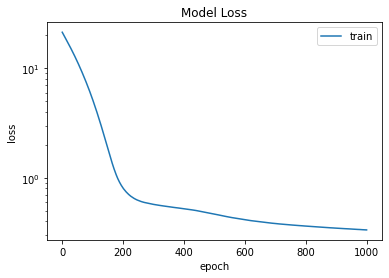

In [30]:
fig = plt.figure()
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

## Evaluate test set
Evaluate the test set using the NN and the actual values

In [31]:
test_eval=model(NN_inputs_test,training=False)
test_eval=scaler_out.inverse_transform(test_eval)
test_eval_df=pd.DataFrame(test_eval,columns=results_EUI.columns)

In [32]:
# test_eval_df
# test_out

## Visually Compare the test dataset

In [33]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

In [35]:
mask = test_eval_df.isnull().values.sum(axis=1)==1
print(mask.sum())

0


In [36]:
_=[plt.plot(test_out.iloc[:,i], test_eval_df.iloc[:,i],'x') for i in range(num_outputs)]
print()

In [37]:
outputs=results_EUI.columns

plt.bar(range(0,len(outputs)*2,2),r2_score(test_out.values[:,:], test_eval_df.values[:,:], multioutput='raw_values'))
plt.ylim([-1,1.05])
ax = plt.gca()
ax2=ax.twinx()

ax2.bar(range(1,len(outputs)*2,2),
        mean_absolute_error(test_out.values[:,:], test_eval_df.values[:,:], multioutput='raw_values'),
       color='orange')

ax.set_xticks(range(1,len(outputs)*2,2))
_=ax.set_xticklabels(outputs, rotation=90)
ax.set_ylabel('R2-score')
ax2.set_ylabel('MAE [eKWh]')
plt.grid=False
print(r2_score(test_out.values[:,:], test_eval_df.values[:,:], multioutput='raw_values'))
print()

[-3.48299703e+00 -3.86653570e-01  8.14942885e-01 -3.89482039e-01
  8.14953143e-01 -3.38126557e+00 -2.23789655e+18 -2.53705386e-01]



In [38]:
results_EUI.columns
end_uses=results_EUI.columns[2:-2]

This plotly chart is an interactive chart that will show the end-use breakdown in bar charts. It compares the results of a NN and the original E+ simulations.

In [39]:
# traces=[]
# buttons=[dict(label = "All",
#                  method = "update",
#                  args = [{"visible": True}])]

# for row in test_eval_df.index.to_list():
#     visibles=[False]*len(test_eval_df.index)
#     visibles[row]=True
    
#     traces.append(
#         go.Bar(
#             x = end_uses,
#             y = test_eval_df.iloc[row][end_uses],
#             name = (f"NN: {row}"),
#             yaxis="y2"
#         ))
    
#     buttons.append(
#     dict(label = str(row),
#                  method = "update",
#                  args = [{"visible": visibles}])
#     )
    
# for row in test_eval_df.index.to_list():
   
#     traces.append(
#         go.Bar(
#             x = end_uses,
#             y = test_out.iloc[row][end_uses],
#             name = (f"E+: {row}"),
#             yaxis="y2"
            
#         ))   
    
# for row in test_eval_df.index.to_list():
   
#     traces.append(
#         go.Table(
#             header=dict(
#                 values=test_in.columns,
#                 font=dict(size=10),
#                 align="left"
#             ),
#             cells=dict(
#                 values=test_in.iloc[row].tolist(),
#                 align = "left")
#         ))    

    
# updatemenus=[dict(active=-1,
#          buttons=buttons)]
    
# layout = dict(title="Dropdown",
#               showlegend=True,
#               xaxis=dict(title="Source"),
#               yaxis=dict(title="Number", range=(-5, test_eval_df[end_uses].max().max()*1.1)),
#               updatemenus=updatemenus,
#               height=600)

# fig = make_subplots(rows=2,cols=1,
#                    row_heights=[.3,.7])
                         
# fig.add_traces(traces)
# fig.update_layout(layout)
# fig.show()

We've noticed that the main parameters affected by this parameter set are the heating:gas, and humidifier:electricity parameters. Let's look at R2 plots for these two parameters

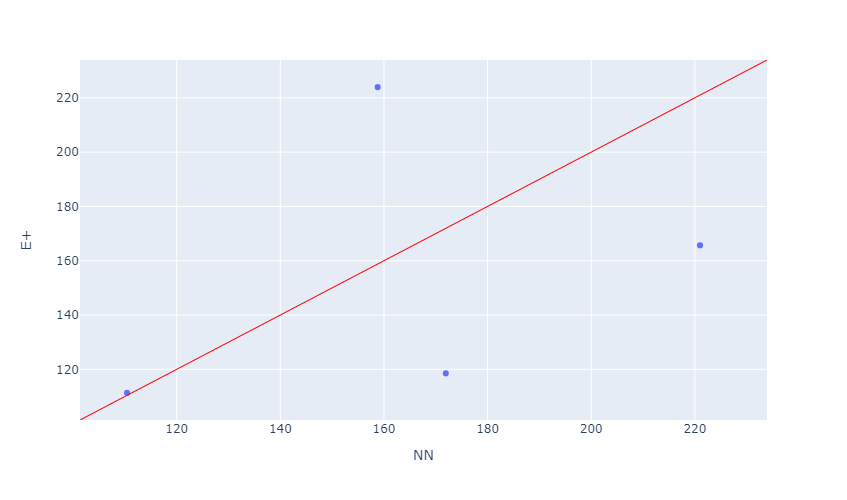

In [40]:
#Scatter subplots of NN vs E+ results

#for now we will do it quickly with express
import plotly.express as px


# traces=[]

# traces.append(
#     go.Scatter(x=test_eval_df['Heating:Gas'],
#               y=test_in['Heating:Gas']))

variable='TEU'
min_range=test_out[variable].min()-10
max_range=test_out[variable].max()+10

fig = px.scatter(x=test_eval_df[variable],y=test_out[variable])
fig.update_layout(
        yaxis=dict(range=[min_range,max_range]),
        xaxis=dict(range=[min_range,max_range]),
        xaxis_title='NN',
        yaxis_title='E+',
        height=500,
        width=500)

fig.add_shape(
        # 1-1 Line
        dict(
            type="line",
            x0=min_range,
            y0=min_range,
            x1=max_range,
            y1=max_range,
            line=dict(
                color="Red",
                width=1
            )))
fig.show()

In [41]:
# #Scatter subplots of NN vs E+ results

# #for now we will do it quickly with express
# import plotly.express as px


# # traces=[]

# # traces.append(
# #     go.Scatter(x=test_eval_df['Heating:Gas'],
# #               y=test_in['Heating:Gas']))

# variable='Cooling:Electricity'
# min_range=test_out[variable].min()-10
# max_range=test_out[variable].max()+10

# fig = px.scatter(x=test_eval_df[variable],y=test_out[variable])
# fig.update_layout(
#         yaxis=dict(range=[min_range,max_range]),
#         xaxis=dict(range=[min_range,max_range]),
#         xaxis_title='NN',
#         yaxis_title='E+',
#         height=500,
#         width=500)

# fig.add_shape(
#         # 1-1 Line
#         dict(
#             type="line",
#             x0=min_range,
#             y0=min_range,
#             x1=max_range,
#             y1=max_range,
#             line=dict(
#                 color="Red",
#                 width=1
#             )))
# fig.show()

# Store metadata

In [42]:
results_EUI.columns=['Electricity:Facility [ekWh/m2]', 'DistrictHeating:Facility [ekWh/m2]',
       'DistrictCooling:Facility [ekWh/m2]', 'Heating:DistrictHeating [ekWh/m2]',
       'Cooling:DistrictCooling [ekWh/m2]', 'InteriorLights:Electricity [ekWh/m2]',
       'InteriorEquipment:Electricity [ekWh/m2]', 'TEU [ekWh/m2]']

In [43]:
inputs_dataframe = inputs_onehot
inputs_index = inputs_onehot.columns
outputs_dataframe = results_EUI
outputs_index = results_EUI.columns
inputs_scaler = scaler_in
outputs_scaler = scaler_out

In [44]:
all_model_metadata = {"inputs_index": inputs_index,
                      "inputs_metadata": inputs_metadata,
                      "model_attributes": model_attributes,
                      "outputs_index": outputs_index,
                      "outputs_metadata": outputs_metadata,
                      "inputs_scaler": inputs_scaler,
                      "outputs_scaler": outputs_scaler,
                      "inputs_dataframe": inputs_dataframe,
                      "outputs_dataframe": outputs_dataframe}

In [45]:
import pickle
pickle.dump(all_model_metadata, open('model_pickle','wb'))

# Store model

In [46]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


# Tensorflow js model

In [47]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model,'model_new')

/usr/local/lib/python3.7/dist-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning:

The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.



In [48]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)